<a href="https://colab.research.google.com/github/JYchoi22117/SSHS_2401/blob/main/practice2_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Google Colab 환경 세팅

- 런타임 유형 변경: T4 GPU (저장)

### 1. 내 드라이브 연결 (1~2분 소요)

- 내 드라이브 연결
- 작업 Directory 이동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# practice로 폴더 생성하지 않고 본인의 폴더명을 별도로 설정하였을 경우, 해당 폴더명을 넣어주기
%cd ./drive/MyDrive/practice

/content/drive/MyDrive/practice


In [3]:
# 현재 directory 확인
%pwd

'/content/drive/MyDrive/practice'

### 2. 분석에 필요한 모듈 및 라이브러리 설치

- Google colab에서 기본적으로 제공하는 모듈도 있음
- 이 외 모듈은 pip install 명령어를 통해 설치
- 설치에는 2~3분 소요

In [4]:
# pip install 설치 명령어

# 데이터 - excel 파일 열기
!pip install openpyxl

# 모델
!pip install transformers
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a287ef7241cbf088fc9851f79df6c1da7c5d95d625e3a8d01e381f4e3e8ce1ab
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


### 3. 설치된 모듈 및 라이브러리 불러오기

In [5]:
# 데이터 처리
import pandas as pd
import numpy as np

# 기본
import time

# 진행 과정 시각화
from tqdm.notebook import tqdm

# 모델 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertPreTrainedModel, BertModel, BertConfig, BertTokenizer, AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models, util
from sentence_transformers.cross_encoder import CrossEncoder

### 4. 분석할 데이터 불러오기

- 소아암 생존자 Q&A 데이터셋

In [7]:
#  데이터 읽기
df = pd.read_excel('data2.xlsx')

# 데이터 첫 5행 읽기
df.head()

# 마지막 5행 읽기
# df.tail()

,question,answer
0,체력이 약화되어 쉽게 피로함을 느껴요.,분명히 남들보다 피로해하는 것은 맞는 것 같고요. 체력이 다른 사람들과 비교했을 때...
1,쉽게 피로해져서 학교 생활에도 제약이 있어요.,뭘 조금만 무리를 하면은 그게 몸에서 반응이 와요. 막 조금만 피곤하게 뭐 공부를 ...
2,수술 후 후유증으로 힘들어요.,방사선 하다 보니까 머리도 가늘어지고 머리 숱도 별로 없더라고요. 그래서 흉터가 보...
3,수술 후유증인지 여성 호르몬 수치가 이상해요.,여성호르몬이 좀 이상하다는 거에요. 인슐린이랑 여성 호르몬 수치가 좀 이상하다고 하...
4,수술 후유증때문에 힘들어요.,"제가 고등학생 때 허리 디스크가 있었는데, 수업 빠질 정도로 가볍지 않은 디스크였어..."


In [6]:
df_chatbot=pd.read_excel('ChatbotDATA.xlsx')

df_chatbot.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [8]:
# 데이터 확인

# 데이터 컬럼명 확인
print(df.columns)

# 데이터 정보 확인
print(df.info())

# 데이터 길이 확인
print(len(df))

Index(['question', 'answer'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  426 non-null    object
 1   answer    426 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB
None
426


### 5. Cross-encoder로 Semantic Textual Similarity(STS) 수행

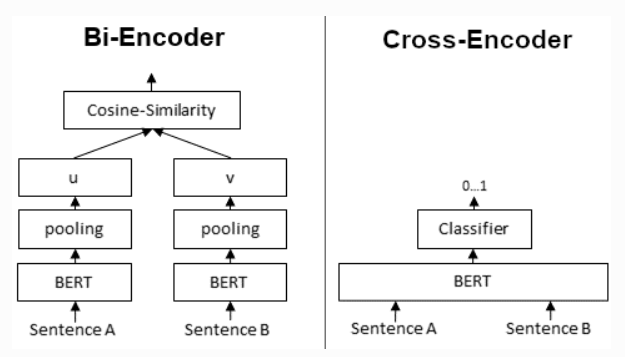

- sbert: https://www.sbert.net/docs/pretrained_models.html
- korean sbert (cross-encoder): https://huggingface.co/bongsoo/klue-cross-encoder-v1

In [9]:
# 사전 학습 BERT model

cross_encoder = CrossEncoder('bongsoo/kpf-cross-encoder-v1') # hugging face 사전 학습 모델 download

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/456M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/276k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
# Testing Question
query = '탈모로 너무 스트레스 받아요.'

# Corpus
question_data = [
    '친구들이 외모 때문에 놀려요.',
    '탈모로 힘들어요.',
    '탈모는 안좋아요.',
    '머리 숱이 너무 없어요.',
    '학교로 돌아갈 수 있으려나.',
    '내가 뭘 잘 할 수 있는지 모르겠어요.',
    '피곤하다.'
    ]

# Cross-encoder input 구조
input_sentence = [[query, question] for question in question_data]

# Compute similarity between two sentences
start = time.time()
similarity_scores = cross_encoder.predict(input_sentence)
end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)
print()

# sort the scores in decreasing order
sim_scores_argsort = np.argsort(similarity_scores)[::-1]

# Print the scores
print("Query:", query)
for idx in sim_scores_argsort:
    print("{:.2f}\t{}".format(similarity_scores[idx], question_data[idx]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


계산 소요시간: 2.449700117111206

Query: 탈모로 너무 스트레스 받아요.
0.66	탈모로 힘들어요.
0.45	탈모는 안좋아요.
0.25	머리 숱이 너무 없어요.
0.02	친구들이 외모 때문에 놀려요.
0.01	내가 뭘 잘 할 수 있는지 모르겠어요.
0.01	피곤하다.
0.00	학교로 돌아갈 수 있으려나.


In [11]:
# 우리 데이터에 적용
# Cross-encoder input 구조
input_sentence = [[query, question] for question in df['question']]

# Compute similarity between two sentences
start = time.time()
similarity_scores = cross_encoder.predict(input_sentence)
end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)

# sort the scores in decreasing order
sim_scores_argsort = np.argsort(similarity_scores)[::-1]

# Print the scores
crossencoder_question = []
print("Query:", query)
for idx in sim_scores_argsort[:5]: # 상위 5개만 출력
    print("{:.2f}\t{}".format(similarity_scores[idx], df['question'][idx]))
    crossencoder_question.append(df['question'][idx])

계산 소요시간: 1.0962748527526855
Query: 탈모로 너무 스트레스 받아요.
0.61	치료 과정 중에 나타나는 탈모와 같은 외모변화 때문에 스트레스를 너무 받아요.
0.61	처음에는 탈모로 인한 외모 변화가 받아들이기 너무 힘들었어요.
0.53	탈모로 인한 외모 변화가 주는 충격이 너무 커요.
0.48	탈모 때문에 자존감이 너무 떨어지는 것 같아요.
0.48	탈모가 계속 지속되는데 어떻게 관리하면 좋을지 모르겠어요.


### 6. Bi-encoder로 STS 수행

- korean sbert: https://huggingface.co/snunlp/KR-SBERT-V40K-klueNLI-augSTS

In [12]:
bi_encoder = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [13]:
# bi-encoder 사전 embedding
new_question_embedding = []

for question in tqdm(df['question']):
    embedding = bi_encoder.encode(question, convert_to_tensor = True)
    new_question_embedding.append(embedding)

print(len(new_question_embedding))

  0%|          | 0/426 [00:00<?, ?it/s]

426


In [14]:
# bi-encoder 사전 embedding
chatbot_embedding = []

for question in tqdm(df_chatbot['Q']):
    embedding = bi_encoder.encode(question, convert_to_tensor = True)
    chatbot_embedding.append(embedding)

print(len(chatbot_embedding))

  0%|          | 0/11823 [00:00<?, ?it/s]

11823


In [15]:
# embedding 파일 별도 저장
import pickle

result = new_question_embedding
result2 = chatbot_embedding

# embedding 값 저장
with open("question_emb.pkl","wb") as f:
    pickle.dump(result, f)

with open("chatbot_emb.pkl","wb") as f:
    pickle.dump(result2, f)


# embedding 파일 불러오기
with open("question_emb.pkl", 'rb') as f:
    new_question_embedding = pickle.load(f)

with open("chatbot_emb.pkl", 'rb') as f:
    chatbot_embedding = pickle.load(f)

In [ ]:
len(new_question_embedding)

426

In [16]:
len(chatbot_embedding)

11823

In [17]:
# Testing Question
query = '탈모로 너무 스트레스 받아요.'

# bi-encoder input 구조
user_emb = bi_encoder.encode(query, convert_to_tensor = True)

# Compute similarity between two sentences
start = time.time()

similarity_score = []
for i in range(len(new_question_embedding)):
    cos_score = util.pytorch_cos_sim(user_emb, new_question_embedding[i])[0]
    similarity_score.append(cos_score)

end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)
print()

# sort the scores in decreasing order
value_score = sorted(similarity_score, reverse = True)
index_score = sorted(range(len(similarity_score)), key=lambda k: similarity_score[k],reverse=True)

# Print the scores
biencoder_question = []
print("Query:", query)
for idx in index_score[:5]: # 상위 5개만 출력
    print("{:.2f}\t{}".format(similarity_score[idx].item(), df['question'][idx]))
    biencoder_question.append(df['question'][idx])

계산 소요시간: 0.16414928436279297

Query: 탈모로 너무 스트레스 받아요.
0.86	탈모 때문에 자존감이 너무 떨어지는 것 같아요.
0.81	치료 과정 중에 나타나는 탈모와 같은 외모변화 때문에 스트레스를 너무 받아요.
0.81	탈모로 인한 외모 변화가 주는 충격이 너무 커요.
0.79	탈모 때문에 계속 사회복귀가 늦어지니깐 그게 너무 고민이에요.
0.77	처음에는 탈모로 인한 외모 변화가 받아들이기 너무 힘들었어요.


**결과 비교**

In [18]:
# cross encoder와 bi encoder 결과 비교
print('비교 입력문:', query)
question = pd.DataFrame()
question['crossencoder'] = crossencoder_question
question['biencoder'] = biencoder_question
question

비교 입력문: 탈모로 너무 스트레스 받아요.


,crossencoder,biencoder
0,치료 과정 중에 나타나는 탈모와 같은 외모변화 때문에 스트레스를 너무 받아요.,탈모 때문에 자존감이 너무 떨어지는 것 같아요.
1,처음에는 탈모로 인한 외모 변화가 받아들이기 너무 힘들었어요.,치료 과정 중에 나타나는 탈모와 같은 외모변화 때문에 스트레스를 너무 받아요.
2,탈모로 인한 외모 변화가 주는 충격이 너무 커요.,탈모로 인한 외모 변화가 주는 충격이 너무 커요.
3,탈모 때문에 자존감이 너무 떨어지는 것 같아요.,탈모 때문에 계속 사회복귀가 늦어지니깐 그게 너무 고민이에요.
4,탈모가 계속 지속되는데 어떻게 관리하면 좋을지 모르겠어요.,처음에는 탈모로 인한 외모 변화가 받아들이기 너무 힘들었어요.


### 7. 소아암 생존자를 위한 정보 전달형 챗봇

In [ ]:
while True:

    print('소아암 생존자:')
    user_context = [str(input())] # 사용자 발화 입력
    start = time.time() # 시작

    # 챗봇 종료 조건
    if user_context == ['종료']:
        check_end = input('대화를 종료할까요? (네/아니오)')
        if check_end == '네':
            print('대화를 종료합니다.')

        time.sleep(1)
        break

    else:
        user_emb = bi_encoder.encode(user_context[0], convert_to_tensor = True)

        final_scores = []

        for sim_score in new_question_embedding:
            cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
            final_scores.append(cos_score.item())


        # alternative
        alter_response = "해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44"

        if np.max(final_scores) <= 0.5:
            best_response = alter_response
        else:
            # select best response with highest score
            max_prob = np.max(final_scores)
            max_idx = np.argmax(final_scores)

            # final response
            best_response = '비슷한 경험을 한 생존자의 이야기를 들려드릴게요.' + df['answer'][max_idx]

        end = time.time() # 끝

        print("저장된 DB 가장 비슷한 질문:", df['question'][max_idx])
        print("챗봇:")
        print(best_response)
        print("답변까지 소요시간:", end-start, '초')
        print()

소아암 생존자:
내가 잘 적응할 수 있을까?
저장된 DB 가장 비슷한 질문: 학교에 돌아가서 다시 잘 적응할 수 있을지 모르겠어요.
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.학교 가면 친구들이 반겨줄까 그런 생각을 많이 했어요. 지금 생각하니깐 슬퍼지네요. 그때는 친구들이 도와주니깐 괜찮았는데요. 지금 생각하니깐 딱 생각이 드는데, 내가 왜 아팠는지 안 아팠으면 좋았을 텐데 그때는 왜 아프지 라는 생각도 없었는데, 지내다 보니깐 지금 생각하니깐 이런 생각이 드네요. 지금은 더 괜찮아요. 더 잘 지내요. 그때는 머리 빠지고, 살찌고 그런 모습이 친구들이 싫어하지 않을까 걱정을 많이 했어요. 그런데 친구들은 잘해줬어요. 친한 애들한테 얘기하고, 담임선생님이 얘기해서 다 퍼져서 다 알게 되었어요. 그 애들도 같이 울어주고, 저는 울려고 하는데 울기가 싫었어요. 왜 그런지 모르지만 울기 싫었고, 눈물도 안 나왔어요. 제가 울면 아빠가 우시니깐 저는 안 울었던 것 같아요. 우는 모습 보이기 싫었어요. 그래서 눈물을 안보인 것 같아요.
답변까지 소요시간: 0.09008932113647461 초

소아암 생존자:
종료
대화를 종료할까요? (네/아니오)네
대화를 종료합니다.


In [26]:
#new
def chatbot_res(ques):
  user_emb = bi_encoder.encode(ques, convert_to_tensor = True)

  final_scores = []

  for sim_score in chatbot_embedding:
    cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
    final_scores.append(cos_score.item())

  # select best response with highest score
  max_prob = np.max(final_scores)
  max_idx = np.argmax(final_scores)

  if np.max(final_scores)<=0.6:
    return("해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44")
  else:
    # final response
    return(df_chatbot['A'][max_idx])

In [28]:
# new

while True:

    print('소아암 생존자:')
    user_context = [str(input())] # 사용자 발화 입력
    start = time.time() # 시작

    # 챗봇 종료 조건
    if user_context == ['종료']:
        check_end = input('대화를 종료할까요? (네/아니오)')
        if check_end == '네':
            print('대화를 종료합니다.')

        time.sleep(1)
        break

    else:
        user_emb = bi_encoder.encode(user_context[0], convert_to_tensor = True)

        final_scores = []

        for sim_score in new_question_embedding:
            cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
            final_scores.append(cos_score.item())


        # alternative
        # alter_response = "해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44"

        if np.max(final_scores) <= 0.6:
            # best_response = alter_response
            best_response=chatbot_res(user_context[0])
        else:
            # select best response with highest score
            max_prob = np.max(final_scores)
            max_idx = np.argmax(final_scores)

            # final response
            best_response = '비슷한 경험을 한 생존자의 이야기를 들려드릴게요.' + df['answer'][max_idx]
            print("저장된 DB 가장 비슷한 질문:", df['question'][max_idx])

        end = time.time() # 끝


        print("챗봇:")
        print(best_response)
        print("답변까지 소요시간:", end-start, '초')
        print()

소아암 생존자:
안녕!
챗봇:
안녕하세요.
답변까지 소요시간: 4.059497356414795 초

소아암 생존자:
놀러가고 싶다
챗봇:
저도요!
답변까지 소요시간: 2.028764247894287 초

소아암 생존자:
학교에 잘 적응할 수 있을까...
저장된 DB 가장 비슷한 질문: 학교에 돌아가서 다시 잘 적응할 수 있을지 모르겠어요.
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.학교 가면 친구들이 반겨줄까 그런 생각을 많이 했어요. 지금 생각하니깐 슬퍼지네요. 그때는 친구들이 도와주니깐 괜찮았는데요. 지금 생각하니깐 딱 생각이 드는데, 내가 왜 아팠는지 안 아팠으면 좋았을 텐데 그때는 왜 아프지 라는 생각도 없었는데, 지내다 보니깐 지금 생각하니깐 이런 생각이 드네요. 지금은 더 괜찮아요. 더 잘 지내요. 그때는 머리 빠지고, 살찌고 그런 모습이 친구들이 싫어하지 않을까 걱정을 많이 했어요. 그런데 친구들은 잘해줬어요. 친한 애들한테 얘기하고, 담임선생님이 얘기해서 다 퍼져서 다 알게 되었어요. 그 애들도 같이 울어주고, 저는 울려고 하는데 울기가 싫었어요. 왜 그런지 모르지만 울기 싫었고, 눈물도 안 나왔어요. 제가 울면 아빠가 우시니깐 저는 안 울었던 것 같아요. 우는 모습 보이기 싫었어요. 그래서 눈물을 안보인 것 같아요.
답변까지 소요시간: 0.08786225318908691 초

소아암 생존자:
탈모때문에 걱정이야.
저장된 DB 가장 비슷한 질문: 탈모 때문에 계속 사회복귀가 늦어지니깐 그게 너무 고민이에요.
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.머리도 하나도 없고… 머리도 안 나고… 머리 스트레스가 좀 컸어요. 처음에는 사람이 좀 간사한지 모르겠지만 그냥 아프지만 않으면 된다 했는데… 머리가 안 나니까… 항암 부작용인 거 같은데 몸이 회복이 안되는데 계속 항암제를 투여를 하니까 이게 세포가 살아날 수 없어요 아예. 머리가. 탈모가 일어난 것 같아요. 그런데 처음엔 교수님이 머리 난대요. 그래서 기다렸는데 안 나요. 

### 8. Option

- Bi-encoder + Cross-encoder

In [ ]:
while True:

    print('소아암 생존자:')
    user_context = [str(input())] # 사용자 발화 입력
    start = time.time() # 시작

    # 챗봇 종료 조건
    if user_context == ['종료']:
        check_end = input('대화를 종료할까요? (네/아니오)')
        if check_end == '네':
            print('대화를 종료합니다.')

        time.sleep(1)
        break

    else:
        rerank_num = int(input())
        user_emb = bi_encoder.encode(user_context[0], convert_to_tensor = True)

        bi_score = []
        rerank_df = pd.DataFrame(columns=['question', 'answer']) # 빈 데이터 프레임 생성

        for sim_score in new_question_embedding:
            cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
            bi_score.append(cos_score.item())

        top_idxes = np.argsort(bi_score)[::-1]

        for i in range(rerank_num):
          rerank_df.loc[i] = [df['question'][top_idxes[i]],df['answer'][top_idxes[i]]]

        # cross-encoder input 구조
        input_sentence = [[user_context[0], question] for question in rerank_df['question']]

        # compute similarity between two sentences
        final_scores = cross_encoder.predict(input_sentence)

        # select best response with the highest score
        max_idx = np.argmax(final_scores)

        # alternative
        alter_response = "해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44"

        if np.max(final_scores) <= 0.5:
            best_response = alter_response
        else:
            # select best response with highest score
            max_prob = np.max(final_scores)
            max_idx = np.argmax(final_scores)

            # final response
            best_response = '비슷한 경험을 한 생존자의 이야기를 들려드릴게요.' + rerank_df['answer'][max_idx]

        end = time.time() # 끝

        print("저장된 DB 가장 비슷한 질문:", rerank_df['question'][max_idx])
        print("챗봇:")
        print(best_response)
        print("답변까지 소요시간:", end-start, '초')
        print()

소아암 생존자:
내가 잘 적응할 수 있을까?
10
저장된 DB 가장 비슷한 질문: 학교에 돌아가서 다시 잘 적응할 수 있을지 모르겠어요.
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.학교 가면 친구들이 반겨줄까 그런 생각을 많이 했어요. 지금 생각하니깐 슬퍼지네요. 그때는 친구들이 도와주니깐 괜찮았는데요. 지금 생각하니깐 딱 생각이 드는데, 내가 왜 아팠는지 안 아팠으면 좋았을 텐데 그때는 왜 아프지 라는 생각도 없었는데, 지내다 보니깐 지금 생각하니깐 이런 생각이 드네요. 지금은 더 괜찮아요. 더 잘 지내요. 그때는 머리 빠지고, 살찌고 그런 모습이 친구들이 싫어하지 않을까 걱정을 많이 했어요. 그런데 친구들은 잘해줬어요. 친한 애들한테 얘기하고, 담임선생님이 얘기해서 다 퍼져서 다 알게 되었어요. 그 애들도 같이 울어주고, 저는 울려고 하는데 울기가 싫었어요. 왜 그런지 모르지만 울기 싫었고, 눈물도 안 나왔어요. 제가 울면 아빠가 우시니깐 저는 안 울었던 것 같아요. 우는 모습 보이기 싫었어요. 그래서 눈물을 안보인 것 같아요.
답변까지 소요시간: 19.1423659324646 초

소아암 생존자:
종료
대화를 종료할까요? (네/아니오)네
대화를 종료합니다.
